In [ ]:
# %%
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
import xgboost as xgb
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Load datasets

file_paths = [
    '/Users/parthgajera/Documents/Thesis_Data/LI-Medium_Trans.csv',
    '/Users/parthgajera/Documents/Thesis_Data/LI-Small_Trans.csv'
]

datasets = [pd.read_csv(fp) for fp in file_paths]


# Feature Engineering Function

def feature_engineering(df):
    df = df.copy()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Hour'] = df['Timestamp'].dt.hour
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
    df['SameBank'] = (df['From Bank'] == df['To Bank']).astype(int)
    df['SameAccount'] = (df['Account'] == df['To Bank']).astype(int)
    df['CurrencyMismatch'] = (df['Receiving Currency'] != df['Payment Currency']).astype(int)
    df['Txn Count From Account'] = df.groupby('Account')['Timestamp'].transform('count')
    df['Rolling Avg From Account'] = df.sort_values(by='Timestamp') \
        .groupby('Account')['Amount Paid'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    return df


# Features

features = [
    'Amount Received', 'Amount Paid',
    'SameBank', 'SameAccount', 'CurrencyMismatch',
    'Txn Count From Account', 'Rolling Avg From Account',
    'Payment Format'
]

hybrid_features = [
    'Amount Received', 'Amount Paid',
    'SameBank', 'SameAccount', 'CurrencyMismatch',
    'Txn Count From Account', 'Rolling Avg From Account',
    'anomaly_score'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Payment Format']),
    ],
    remainder='passthrough'
)




In [ ]:

# 4. Training isolation forest

train_df = feature_engineering(datasets[0])
X_train_iso = train_df[features]

iso_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('iso_forest', IsolationForest(
        n_estimators=100,
        max_samples=50000,
        contamination=0.02,
        max_features=1.0,
        random_state=42,
        n_jobs=-1
    ))
])

iso_pipeline.fit(X_train_iso)

# Add anomaly scores
X_train_iso_transformed = iso_pipeline.named_steps['preprocess'].transform(X_train_iso)
train_df['anomaly_score'] = iso_pipeline.named_steps['iso_forest'].decision_function(X_train_iso_transformed)
train_df['anomaly_label'] = iso_pipeline.named_steps['iso_forest'].predict(X_train_iso_transformed)
train_df['anomaly_label'] = train_df['anomaly_label'].map({1: 'Normal', -1: 'Anomaly'})
train_df['hybrid_label'] = train_df['anomaly_label'].map({'Anomaly': 1, 'Normal': 0})

# Final Label
train_df['final_label'] = np.where(
    (train_df['Is Laundering'] == 1), 1, 
    np.where((train_df['hybrid_label'] == 1), 2, 0)
)



In [ ]:

# Preparing Hybrid Data

X_hybrid = train_df[hybrid_features]
y_hybrid = train_df['final_label']


# 6. Downsampling

minority_df = train_df[train_df['final_label'] != 0]
majority_df = train_df[train_df['final_label'] == 0].sample(frac=0.1, random_state=42)

hybrid_sample_df = pd.concat([minority_df, majority_df])

X_hybrid_sample = hybrid_sample_df[hybrid_features]
y_hybrid_sample = hybrid_sample_df['final_label']

print(f"After downsampling, class distribution:\n{y_hybrid_sample.value_counts()}")


After downsampling, class distribution:
final_label
0    3061104
2     624398
1      16041
Name: count, dtype: int64


In [ ]:

# SMOTETomek

smote_tomek = SMOTETomek(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = smote_tomek.fit_resample(X_hybrid_sample, y_hybrid_sample)

print(f"After SMOTETomek resampling, class distribution:\n{y_resampled.value_counts()}")

After SMOTETomek resampling, class distribution:
final_label
1    3009247
2    2989559
0    2964548
Name: count, dtype: int64


In [ ]:

# Train XGBoost

model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    n_jobs=-1,
    use_label_encoder=False,
    random_state=42
)

model.fit(X_resampled, y_resampled)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:34:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1, num_class=3, ...)

In [ ]:

# Prepare Test Data (dataset[1])

test_df = feature_engineering(datasets[1])
X_test_iso = test_df[features]

# Transform using Isolation Forest
X_test_iso_transformed = iso_pipeline.named_steps['preprocess'].transform(X_test_iso)
test_df['anomaly_score'] = iso_pipeline.named_steps['iso_forest'].decision_function(X_test_iso_transformed)
test_df['anomaly_label'] = iso_pipeline.named_steps['iso_forest'].predict(X_test_iso_transformed)
test_df['anomaly_label'] = test_df['anomaly_label'].map({1: 'Normal', -1: 'Anomaly'})
test_df['hybrid_label'] = test_df['anomaly_label'].map({'Anomaly': 1, 'Normal': 0})

# Final Label for test data for evaluation
if 'Is Laundering' in test_df.columns:
    test_df['final_label'] = np.where(
        (test_df['Is Laundering'] == 1), 1, 
        np.where((test_df['hybrid_label'] == 1), 2, 0)
    )
else:
    test_df['final_label'] = np.where(
        (test_df['hybrid_label'] == 1), 2, 0
    )

X_test = test_df[hybrid_features]
y_test = test_df['final_label']

In [23]:
y_pred = model.predict(X_test)

print("\nClassification Report on Dataset[1]:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report on Dataset[1]:
              precision    recall  f1-score   support

           0     0.9998    0.8446    0.9157   6759473
           1     0.0029    0.8595    0.0058      3565
           2     0.9661    0.9920    0.9789    161011

    accuracy                         0.8480   6924049
   macro avg     0.6563    0.8987    0.6335   6924049
weighted avg     0.9985    0.8480    0.9167   6924049



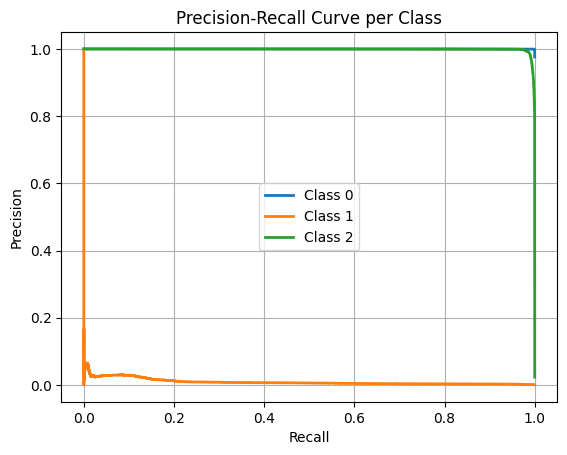

In [25]:
y_probs = model.predict_proba(X_test)
precision = dict()
recall = dict()

for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve((y_test == i).astype(int), y_probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Class')
plt.legend()
plt.grid()
plt.show()